In [1]:
from sklearn.datasets import load_svmlight_file
import torch
import matplotlib.pyplot as plt

In [2]:
# Load the training dataset
X_train, y_train = load_svmlight_file('./libsvm_data/a9a.txt')

# Load the testing dataset
X_test, y_test = load_svmlight_file('./libsvm_data/a9a_t.txt')

# Convert to PyTorch tensors
X_train = torch.from_numpy(X_train.toarray()).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test.toarray()).float()
y_test = torch.from_numpy(y_test).float()


In [2]:
from torch.utils.data import Dataset, DataLoader
# LIBSVM dataset
class LIBSVM(torch.utils.data.Dataset):
    def __init__(self, path):
        super().__init__()
        # Load the dataset
        data, targets = load_svmlight_file(path, n_features = 123)

        # Convert targets for values in {0, 1}
        targets = (targets + 1) / 2
        
        # Convert to PyTorch tensors
        data = torch.from_numpy(data.toarray()).float()
        targets = torch.from_numpy(targets).float()

        self.data = data
        self.targets = targets
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index], self.targets[index]

    
# Create datasets and dataloaders
train_path = './libsvm_data/a9a.txt'
test_path = './libsvm_data/a9a_t.txt'

train_dataset = LIBSVM(train_path)
test_dataset = LIBSVM(test_path)

In [3]:
train_dataset.targets

tensor([0., 0., 0.,  ..., 0., 0., 1.])

In [7]:
class libsvm_model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(123, 1)
    
    def forward(self, x):
        x = self.linear(x)
        return torch.sigmoid(x)


In [71]:
# Hyperparams
lr = 1e-1
weight_decay = 1e-4
batch_size = 128

# DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model
model = libsvm_model()

# Loss and Optimizer
loss_fn = torch.nn.BCELoss()

optimizer = torch.optim.SGD(params= model.parameters(), lr = lr, weight_decay= weight_decay)

def criterion(output, targets):
    # return a tensor of shape (1, 2), where [number of correct pred, batch_size]
    # Transform all values of preds to 0 (if value < 0.5) and 1
    preds = 1 * (output > torch.ones_like(output).mul_(0.5))
    
    return torch.tensor([(preds.view(1, -1).int() == targets.int()).sum(), len(targets)])

def evaluate(output, targets):
    accuracy = criterion(output, targets)
    return accuracy[0].item() / accuracy[1].item()

In [72]:
t = 1 * (torch.tensor([0.5, 0.2, 0.8]) > torch.ones(3).mul_(0.5))
t

tensor([0, 0, 1])

In [73]:
# Training
epochs = 100
track_loss = []
for epoch in range(epochs):
    model.train()
    for i, data in enumerate(train_dataloader):
        X, y = data
        optimizer.zero_grad()
        output = model(X)
        loss = loss_fn(output, y.view(-1, 1))
        loss.backward()
        optimizer.step()

        # evaluate training
        if i%50 == 0:
            #print(f"train accuracy at batch number {i} : {evaluate(output, y)}")
            track_loss.append(loss.detach().numpy())


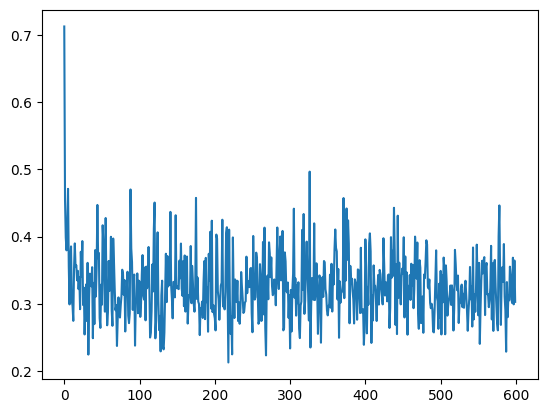

In [74]:
plt.plot(track_loss)

In [75]:
# Testing
accuracy = torch.zeros(2)
model.eval()
for i, data in enumerate(test_dataloader):
    X, y = data
    accuracy += criterion(model(X), y)
    #print(loss_fn(model(X), y))
    #print(criterion(model(X), y))

print(f"The result of the evaluation over the test set is {accuracy[0].item() / accuracy[1].item()}")

The result of the evaluation over the test set is 0.850316319636386
